# 3-2 patsyのモデル式を使おう！
モデル式とは、モデルの中から目的変数と説明変数を抜き出して表現したものです。

目的変数yと説明変数x1, x2を使うと、モデル式は、y ~ x1 + x2のように表現します。
モデル式は、y = β0 + β1 * x1 + β2 * x2 + ε（εは誤差）というモデルに対応します。

patsyというライブラリーでモデル式を扱えます。


In [1]:
%matplotlib inline
%precision 3
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from patsy import dmatrix
from sklearn.datasets import load_boston
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from pandas.plotting import scatter_matrix
pd.set_option('display.precision', 3)  # 小数点以下3桁に

In [2]:
boston = load_boston()

X = pd.DataFrame(boston.data, columns = boston.feature_names)
y = boston.target
X[:1]

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.006,18.0,2.31,0.0,0.538,6.575,65.2,4.09,1.0,296.0,15.3,396.9,4.98


In [3]:
# 目的変数(MEDV)と各説明変数との相関係数
Xy = X.assign(MEDV = y )

Xy.corr().MEDV

CRIM      -0.386
ZN         0.360
INDUS     -0.484
CHAS       0.175
NOX       -0.427
RM         0.695
AGE       -0.377
DIS        0.250
RAD       -0.382
TAX       -0.469
PTRATIO   -0.508
B          0.333
LSTAT     -0.738
MEDV       1.000
Name: MEDV, dtype: float64

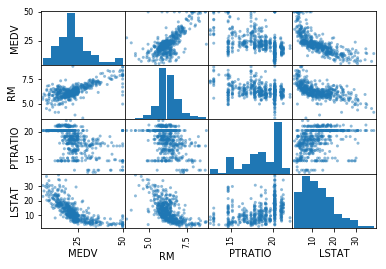

In [4]:
# 散布図行列を確認
scatter_matrix(Xy[['MEDV', 'RM', 'PTRATIO', 'LSTAT']]);

In [10]:
# モデル式から説明変数の表を作成
X1 = dmatrix('RM + PTRATIO + LSTAT -1' , data = X, 
            return_type ='dataframe')
#- 1は、y切片を0にするという意味

X1[:1]

,RM,PTRATIO,LSTAT
0,6.575,15.3,4.98


## patsy.dmatrixの主なオプション
dmatrixの第1引数は、省略不可で、モデルオブジェクトを指定します。

dataには、列名をキーとした辞書相当を指定します。pandas.DataFrameも指定できます。
return_typeを指定しないと、結果がnumpy.ndarrayになります。return_type='dataframe'とすると、結果はpandas.DataFrameになります。

In [9]:
# 線形回帰でクロスバリデーション
scores = cross_val_score(LinearRegression(), X1, y, cv=6)
score1 = scores.mean()
score1

0.472

# モデル式の修正
目的変数MDEVと説明変数LSTATの関係を見ます。
直線というより指数分布に近い形をしています。試しに、np.log(Xy.LSTAT)の関係を見てみます。直線に近づきました。

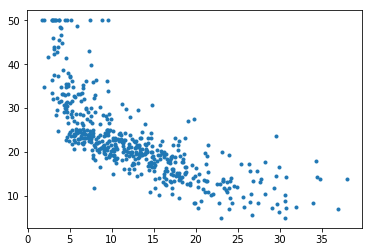

In [11]:
# LSTATとMEDVの関係
plt.plot(Xy.LSTAT, Xy.MEDV, '.');

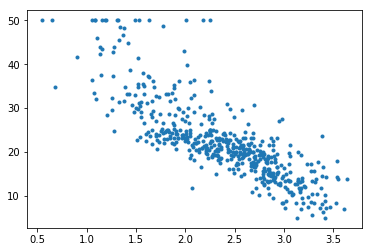

In [12]:
# log(LSTAT)toMEDVの関係
plt.plot(np.log(Xy.LSTAT), Xy.MEDV, '.');

In [13]:
# モデル式から説明変数の表を作成
X2 = dmatrix('RM + PTRATIO + np.log(LSTAT) - 1', data=X,
             return_type='dataframe')
X2[:1]

,RM,PTRATIO,np.log(LSTAT)
0,6.575,15.3,1.605


In [15]:
# 線形回帰でクロスバリデーション
scores = cross_val_score(LinearRegression(), X2, y, cv=6)
score2 = scores.mean()
score2

0.549

# 色々なモデル式
モデル式を使うと、簡単にモデルを変更できます。
使える記号を学びます

In [16]:
# モデル式から説明変数の表を作成
X3 = dmatrix('RM * PTRATIO + np.log(LSTAT) - 1', data=X,
             return_type='dataframe')
X3[:2]

,RM,PTRATIO,RM:PTRATIO,np.log(LSTAT)
0,6.575,15.3,100.598,1.605
1,6.421,17.8,114.294,2.213


In [17]:
# 線形回帰でクロスバリデーション
scores = cross_val_score(LinearRegression(), X3, y, cv=6)
score3 = scores.mean()
score3

0.625

In [18]:
# RM:PTRATIO は、RM * PTRATIO
(X3['RM:PTRATIO'] == X3.RM * X3.PTRATIO).all()

True

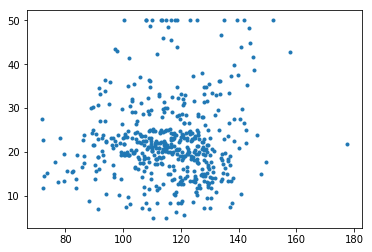

In [19]:
plt.plot(Xy.RM * Xy.PTRATIO, Xy.MEDV, '.');

'RM + PTRATIO + np.log(LSTAT) - 1'を'RM * PTRATIO + np.log(LSTAT) - 1'に変更してみます（最初の+を*に）。
RM:PTRATIOという列が追加されます。
決定係数の平均は、0.625に上がりました。
列RM:PTRATIOは、RMとPTRATIOを掛けたものです。
RMとPTRATIOを掛けたものとMEDVの散布図を見ると、相関は高くありません。従って、決定係数が良くなったのは偶然の可能性が高いです。